# TZ Gaming: Optimal Targeting of Mobile Ads

In [590]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from matplotlib.pyplot import figure

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 200

In [591]:
# loading data
tz_gaming = pd.read_pickle("data/tz_gaming.pkl")

In [592]:
# see data description
rsm.describe(tz_gaming)

### TZ Gaming: Optimal Targeting of Mobile Ads

Each row in the `tz_gaming` dataset represents an impression. For each row (impression), we have data on 21 variables. All explanatory variables are created by Vneta based on one month tracking history of users, apps, and ads. The available variables are described in below. 

* _training_ -- Dummy variable that splits the dataset into a training ("train") and a test ("test") set
* _inum_ -- Impression number
* _click_ -- Click indicator for the TZ ad served in the impression. Equals "yes" if the ad was clicked and "no" otherwise
* _time_ -- The hour of the day in which the impression occurred (1-24). For example, "2" indicates the impression occurred between 1 am and 2 am
* _time\_fct_ -- Same as _time_ but the is coded as categorical 
* _app_ -- The app in which the impression was shown. Ranges from 1 to 49
* _mobile\_os_ -- Customer's mobile OS
* _impup_ -- Number of past impressions the user has seen in the app
* _clup_ -- Number of past impressions the user has clicked on in the app
* _ctrup_ -- Past CTR (Click-Through Rate) (x 100) for the user in the app
* _impua_ -- Number of past impressions of the TZ ad that the user has seen across all apps
* _clua_ -- Number of past impressions of the TZ ad that the user has clicked on across all apps
* _ctrua_ -- Past CTR (x 100) of the TZ ad by the user across all apps
* _imput_ -- Number of past impressions the user has seen within in the hour
* _clut_ -- Number of past impressions the user has clicked on in the hour
* _ctrut_ -- Past CTR (x 100) of the user in the hour
* _imppat_ -- Number of past impressions that showed the TZ ad in the app in the hour
* _clpat_ -- Number of past clicks the TZ ad has received in the app in the hour
* _ctrpat_ -- Past CTR (x 100) of the TZ ad in the app in the hour
* _rnd_ -- Simulated data from a normal distribution with mean 0 and a standard deviation of 1
* _pred\_vneta_ -- Predicted probability of click per impressions generated by Vneta's proprietary machine learning algorithm
* id -- Anonymized user ID

Note that there is a clear relationship between the impressions, clicks, and ctr variables within a strata. Specifically: 

* ctrup = clup/impup
* ctru = clu/impu
* ctrut = clut/imput
* ctrpat = clpat/impat

The last three letters of a feature indicate the sources of variation in a variable:

* u — denotes user
* t — denotes time
* p — denotes app
* a — denotes ad 



## Part I: Logistic regression

a. Estimate a logistic regression model with the following variables `time_fct app mobile_os impua clua ctrua` as the explanatory variables (features) and `click_yes` as the response variable (target)

> Note: Use only the rows that are labeled `train` in the `training` variable

In [593]:
tz_gaming["click_yes"] = rsm.ifelse(tz_gaming.click == "yes", 1, 0)

In [594]:
tz_gaming[tz_gaming['training'] == 'train']

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,imput,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id,click_yes
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,25,0,0.000000,71,1,1.408451,-1.207066,0.003961,id247135,0
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,7,0,0.000000,67312,1069,1.588127,0.277429,0.003961,id245079,0
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,94,0,0.000000,331,1,0.302115,1.084441,0.003961,id927245,0
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,19,0,0.000000,71114,1001,1.407599,-2.345698,0.018965,id922188,0
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,329,4,1.215805,183852,2317,1.260253,0.429125,0.003961,id355833,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87530,train,I299985,no,11,11,app2,android,1181,0,0.000000,...,55,0,0.000000,9625,14,0.145455,-0.249031,0.003961,id565693,0
87531,train,I299986,no,10,10,app33,ios,1885,0,0.000000,...,374,0,0.000000,658,1,0.151976,0.770718,0.003961,id222657,0
87532,train,I299990,no,1,1,app45,ios,8,0,0.000000,...,15,0,0.000000,166,7,4.216867,0.181559,0.018965,id340594,0
87533,train,I299991,no,8,8,app1,ios,113,2,1.769912,...,0,0,0.000000,14245,158,1.109161,-1.263831,0.003961,id634151,0


In [595]:
# Logistic regression via statsmodel (using the formula API)
lr = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data=tz_gaming[tz_gaming['training'] == 'train']
).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87458
Model Family:                Binomial   Df Model:                           76
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3946.1
Date:                Thu, 03 Feb 2022   Deviance:                       7892.1
Time:                        18:27:19   Pearson chi2:                 1.60e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.5282      0.197    -17.936      0.000      -3.914      -3.143
time_fct[T.2]         -0.4741      0.321     -1.478      0.139      -1.103       0.155
time_fct[T.3]         -0.3317      0.454     -0.730      0.466      -1.222       0.559
time_fct[T.4]        -23.5430    4.2e+04     -0.001      1.000   -8.24e+04    8.23e+04
time_fct[T.5]        -23.7205   5.52e+04     -0.000      1.000   -1.08e+05    1.08e+05
time_fct[T.6]         -1.0516      1.021     -1.030      0.303      -3.053       0.950
time_fct[T.7]          0.1997      0.426      0.468      0.640      -0.636       1.036
time_fct[T.8]          0.0992      0.296      0.335      0.737      -0.481       0.679
time_fct[T.9]          0.0289      0.287      0.101      0.920      -0.534       0.592
time_fct[T.10]        -0.1866      0.295     -0.633      0.527      -0.764       0.391
time_fct[T.11]        -0.4515      0.276     -1.635      0.102      -0.993       0.090
time_fct[T.12]        -0.1351      0.280     -0.483      0.629      -0.683       0.413
time_fct[T.13]        -0.5281      0.290     -1.823      0.068      -1.096       0.040
time_fct[T.14]         0.0944      0.225      0.419      0.675      -0.347       0.536
time_fct[T.15]        -0.0140      0.225     -0.062      0.951      -0.455       0.428
time_fct[T.16]         0.0453      0.233      0.195      0.846      -0.411       0.502
time_fct[T.17]         0.0138      0.250      0.055      0.956      -0.477       0.504
time_fct[T.18]         0.0595      0.247      0.241      0.809      -0.424       0.543
time_fct[T.19]         0.2500      0.233      1.072      0.284      -0.207       0.707
time_fct[T.20]         0.2019      0.231      0.873      0.382      -0.251       0.655
time_fct[T.21]        -0.1422      0.244     -0.584      0.559      -0.620       0.335
time_fct[T.22]        -0.0302      0.238     -0.127      0.899      -0.496       0.436
time_fct[T.23]         0.0428      0.238      0.180      0.857      -0.424       0.509
time_fct[T.24]         0.0941      0.229      0.410      0.682      -0.356       0.544
app[T.app2]           -2.0905      0.229     -9.127      0.000      -2.539      -1.642
app[T.app3]           -1.6937      1.003     -1.689      0.091      -3.659       0.272
app[T.app4]           -0.9601      0.321     -2.988      0.003      -1.590      -0.330
app[T.app5]           -1.2644      1.005     -1.258      0.208      -3.234       0.705
app[T.app6]           -0.4288      0.175     -2.457      0.014      -0.771      -0.087
app[T.app7]           -0.5169      1.007     -0.513      0.608      -2.491       1.458
app[T.app8]          -24.3740   7.17e+04     -0.000      1.000   -1.41e+05     1.4e+05
app[T.app9]           -0.2899      0.236     -1.227      0.220      -0.753       0.173
app[T.app10]         -23.8906   6.71e+

##### For categorical predictors like app and mobile_os, the above corresponding coeeficients represent that at teach level, all else equal, being this type would have this coefficient amount of change in  chance likely to (associate on average with) click yes than not being this type.
##### For numeric predictors like impua, clua, and ctrua, their coefficients represent that for one unit increase in this variable, all else equal, is on average associate with this coefficient change in likelyhood of click yes.
# 

b. Summarize and interpret the logistic regression results. Provide an interpretation of the odds-ratios estimated for the explanatory variables `mobile_os`, `impua`, `clua`, and `ctrua` and an evaluation of the model as a whole. Which of these explanatory variables are statistically significant? Which variables seem to be most "important"?

> Hint: The Chi-square test for a logistic regression model is equivalent to an F-test for a linear regression model

In [596]:
# discuss and add any code need to calculate additional statistics
# you may need (e.g., rsm.or_ci(lr)[71:] and rsm.model_fit(lr))
rsm.or_ci(lr)[71:]

,index,OR,OR%,2.5%,97.5%,p.values,
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.979,-2.1%,0.975,0.982,< .001,***
75,clua,1.295,29.5%,1.156,1.451,< .001,***
76,ctrua,1.022,2.2%,1.017,1.026,< .001,***


##### We have the assumption of all else equal for the following conclusions. And all implications are subjective (concluded from observation).
##### According to the Odds Ratio table above, obs with ios systems are 0.45 times more likely to be observed click yes than others who do not use ios, which suggests a negative relationship between being a iosuser and to be observed as click yes.
##### According to the Odds Ratio table above, obs with other systems are 0.71945 times more likely to be observed click yes than others who do not use others, which suggests a negative relationship between being a other system user and to be observed as click yes.
##### According to the Odds Ratio table above, obs who has one unit increase in 'impua' are 0.979 times more likely to be observed click yes than others who do not, which suggests a negative relationship between units increase in 'impua' and to be observed as click yes.
##### According to the Odds Ratio table above, obs who has one unit increase in 'clua'  are 1.295 times more likely to be observed click yes than others who do not, which suggests a positive relationship between units increase in 'clua' and to be observed as click yes.
##### According to the Odds Ratio table above, obs who has one unit increase in 'ctrua' are 1.022 times morte likely to be observed click yes than others who do not, which suggests a positive relationship between units increase in 'ctrua' and to be observed as click yes.
# 

In [597]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535



##### According to the two tables above, as we measure the significant according to 0.001 level, all these variables are significant except other os system (users).
##### Among the most statistically significant predictors (p-value < 0.001), Clua seems to be the most significant among others due to its highest OR, which represents that having a higher amount of clue would imply a higher probability of clicking yes for (observed) customers. And we want to have more customers clicking yes.
# 

c. Predict the probability of a click

The estimated logistic regression model can predict the probability of `click_yes == 1`. Create a new variable `pred_logit` with the predicted click-through probabilities linked to each impression. Make sure to generate predictions for all rows in the training and test data.

In [598]:
tz_gaming["pred_logit"] = lr.predict(tz_gaming[['time_fct', 'app', 'mobile_os', 'impua', 'clua', 'ctrua' ]])

In [599]:
tz_gaming["pred_logit"]

0         3.382977e-13
1         1.156355e-02
2         2.655311e-03
3         1.349420e-02
4         1.868222e-03
              ...     
115483    1.093091e-03
115484    3.609483e-03
115485    2.052670e-02
115486    2.192207e-02
115487    1.170346e-02
Name: pred_logit, Length: 115488, dtype: float64

d. Re-estimate the logistic regression after standardizing the numeric explanatory variables (see sample code below). What is the interpretation of the standardized odds-ratios for the explanatory variables? Which variables seem to be most important now and how does this compare to your conclusions from (b) above? Has the model fit changed after you standardized the variables?

> Tip: Use `or_plot` from the `pyrsm` packages to visualize the (standardized) odds-ratios.

> Tip: Check the mean, std, min, and max for the transformed variables

In [600]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

##### mean, std, min, max

In [601]:
tz_std[["impup", "ctrpat"]].describe()

,impup,ctrpat
count,115488.000000,115488.000000
mean,0.000928,0.010373
std,1.002776,1.000947
min,-0.567816,-1.276072
25%,-0.483849,-0.986955
50%,-0.267723,0.274560
75%,0.160554,0.636642
max,22.296324,10.371197


In [602]:
# estimate your model and assign the fitted model to lr_std
lr_std = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training'] == 'train']
).fit()
lr_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87458
Model Family:                Binomial   Df Model:                           76
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3946.1
Date:                Thu, 03 Feb 2022   Deviance:                       7892.1
Time:                        18:30:51   Pearson chi2:                 1.60e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.3613      0.197    -22.110      0.000      -4.748      -3.975
time_fct[T.2]         -0.4741      0.321     -1.478      0.139      -1.103       0.155
time_fct[T.3]         -0.3317      0.454     -0.730      0.466      -1.222       0.559
time_fct[T.4]        -23.5430    4.2e+04     -0.001      1.000   -8.24e+04    8.23e+04
time_fct[T.5]        -23.7205   5.52e+04     -0.000      1.000   -1.08e+05    1.08e+05
time_fct[T.6]         -1.0516      1.021     -1.030      0.303      -3.053       0.950
time_fct[T.7]          0.1997      0.426      0.468      0.640      -0.636       1.036
time_fct[T.8]          0.0992      0.296      0.335      0.737      -0.481       0.679
time_fct[T.9]          0.0289      0.287      0.101      0.920      -0.534       0.592
time_fct[T.10]        -0.1866      0.295     -0.633      0.527      -0.764       0.391
time_fct[T.11]        -0.4515      0.276     -1.635      0.102      -0.993       0.090
time_fct[T.12]        -0.1351      0.280     -0.483      0.629      -0.683       0.413
time_fct[T.13]        -0.5281      0.290     -1.823      0.068      -1.096       0.040
time_fct[T.14]         0.0944      0.225      0.419      0.675      -0.347       0.536
time_fct[T.15]        -0.0140      0.225     -0.062      0.951      -0.455       0.428
time_fct[T.16]         0.0453      0.233      0.195      0.846      -0.411       0.502
time_fct[T.17]         0.0138      0.250      0.055      0.956      -0.477       0.504
time_fct[T.18]         0.0595      0.247      0.241      0.809      -0.424       0.543
time_fct[T.19]         0.2500      0.233      1.072      0.284      -0.207       0.707
time_fct[T.20]         0.2019      0.231      0.873      0.382      -0.251       0.655
time_fct[T.21]        -0.1422      0.244     -0.584      0.559      -0.620       0.335
time_fct[T.22]        -0.0302      0.238     -0.127      0.899      -0.496       0.436
time_fct[T.23]         0.0428      0.238      0.180      0.857      -0.424       0.509
time_fct[T.24]         0.0941      0.229      0.410      0.682      -0.356       0.544
app[T.app2]           -2.0905      0.229     -9.127      0.000      -2.539      -1.642
app[T.app3]           -1.6937      1.003     -1.689      0.091      -3.659       0.272
app[T.app4]           -0.9601      0.321     -2.988      0.003      -1.590      -0.330
app[T.app5]           -1.2644      1.005     -1.258      0.208      -3.234       0.705
app[T.app6]           -0.4288      0.175     -2.457      0.014      -0.771      -0.087
app[T.app7]           -0.5169      1.007     -0.513      0.608      -2.491       1.458
app[T.app8]          -24.3740   7.17e+04     -0.000      1.000   -1.41e+05     1.4e+05
app[T.app9]           -0.2899      0.236     -1.227      0.220      -0.753       0.173
app[T.app10]         -23.8906   6.71e+

##### Standardizing the numerical variables changed the measurement in interpretation. It's now how many units of standard deviation change instad of value change.
##### For categorical predictors like app and mobile_os, the above corresponding coeeficients represent that at teach level, all else equal, being this type would have this coefficient change in probability of likely to (associate on average with) clicking yes than not being this type.
##### For numeric predictors like impua, clua, and ctrua, their coefficients represent that for one unit increase of its stander deviation in this variable, all else equal, is on average associate with this coefficient change in likelyhood of click yes.
# 

In [607]:
rsm.or_ci(lr_std)[71:]

,index,OR,OR%,2.5%,97.5%,p.values,
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.236,-76.4%,0.184,0.303,< .001,***
75,clua,1.176,17.6%,1.095,1.262,< .001,***
76,ctrua,1.127,12.7%,1.098,1.156,< .001,***


##### Since we are comparing each predictor on the measurement of their standard deviation, we cannot draw conclusion only based on their OR ratios unless we take each of their SD into consideration.

In [605]:
rsm.model_fit(lr_std)


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535



##### The standardized model does not have obvious change in either its R-square, AUC, AIC nor BIC.

<AxesSubplot:xlabel='Odds-ratio'>

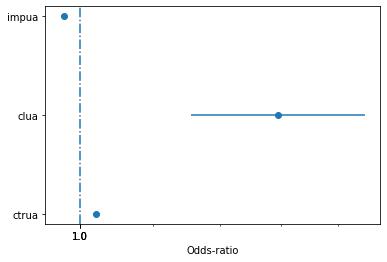

In [608]:
rsm.or_plot(lr, incl = ['impua', 'clua', 'ctrua'])

<AxesSubplot:xlabel='Odds-ratio'>

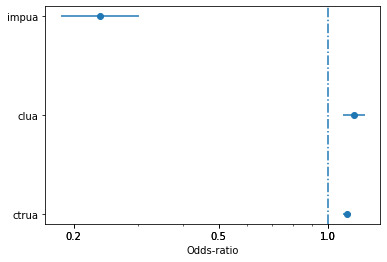

In [609]:
rsm.or_plot(lr_std, incl = ['impua', 'clua', 'ctrua'])

##### From the above OR plots (original & standardized), we can tell the odds ratio of impua and clua both dropped, but the OR of Ctrua doesn't has significant change. 
##### A potential explanation of impua's change is that it has large standard deviation, thus has less impact on outcome variable when measurement switched to sd. The same also applies to clua.
##### However, since the OR of ctrua doesn't change much, we may suggest it's more stable and have a less standard deviation.
# 

e. Estimate a logistic regression with `click_yes` as the response variable and `rnd` as the only explanatory variable. As before, the model should be estimated on the training sample (i.e., `training == 'train'`). Create a new variable `pred_rnd` with the predicted click-through probabilities.

In [610]:
# add your code
lr_rnd = smf.glm(
    formula="click_yes ~ rnd",
    family=Binomial(link=logit()),
    data=tz_gaming[tz_gaming['training'] == 'train']
).fit()

tz_gaming["pred_rnd"] = lr_rnd. predict (tz_gaming['rnd'])

In [611]:
tz_gaming[:5]

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id,click_yes,pred_logit,pred_rnd
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,0.000000,71,1,1.408451,-1.207066,0.003961,id247135,0,3.382977e-13,0.009222
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,0.000000,67312,1069,1.588127,0.277429,0.003961,id245079,0,1.156355e-02,0.008751
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,0.000000,331,1,0.302115,1.084441,0.003961,id927245,0,2.655311e-03,0.008505
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,0.000000,71114,1001,1.407599,-2.345698,0.018965,id922188,0,1.349420e-02,0.009600
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,1.215805,183852,2317,1.260253,0.429125,0.003961,id355833,0,1.868222e-03,0.008704


## Part II: Understanding Multicollinearity

a. Estimate a logistic regression model with `click_yes` as the response variable and `imppat`, `clpat`, and
`ctrpat` as the only explanatory variable. Make sure to standardize the explanatory variables before estimation (see example code below). What is the interpretation of the standardized odds-ratios for the explanatory variables?

In [612]:
# select variables to standardize
to_std = tz_gaming.loc[:, "imppat":"ctrpat"].columns
# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

In [613]:
# add your code to estimate the model
lr_mc1 = smf.glm(formula="click_yes ~ imppat + clpat + ctrpat",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training'] == 'train']
).fit()
lr_mc1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87531
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4273.1
Date:                Thu, 03 Feb 2022   Deviance:                       8546.2
Time:                        19:54:48   Pearson chi2:                 8.16e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9146      0.043   -114.228      0.000      -4.999      -4.830
imppat        -1.0050      0.209     -4.802      0.000      -1.415      -0.595
clpat          1.2293      0.215      5.713      0.000       0.808       1.651
ctrpat         0.3527      0.025     13.933      0.000       0.303       0.402
==============================================================================
"""

In [614]:
rsm.or_ci(lr_mc1)

,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,0.366,-63.4%,0.243,0.552,< .001,***
2,clpat,3.419,241.9%,2.242,5.212,< .001,***
3,ctrpat,1.423,42.3%,1.354,1.495,< .001,***


##### For numeric predictors like impua, clpat, and ctrapat, their coefficients represent that for one unit increase of its stander deviation in this variable, all else equal, is on average associate with this coefficient change in likelyhood of click yes.
##### For imppat, all else equal, one sd amount of increase in clpat value is associate on average with 0.366 times more likely of clicking yes in the observed dataset.
##### For clpat, all else equal, one sd amount of increase in clpat value is associate on average with 3.419 times more likely of clicking yes in the observed dataset.
##### For ctrpat, all else equal, one sd amount of increase in ctrpat	 value is associate on average with 1.423 times  more likely of clicking yes in the observed dataset.
# 

b. Some of the variables in the dataset are highly correlated with each other. In particular, imppat
and clpat have a positive correlation of 0.97. Discuss the implications of this (very) high level of
collinearity and also different approaches to deal with it. What are the implications for the model and
the interpretation of the estimated (standardized) coefficients? As part of your answer, discuss the
change in the estimated (standardized) odds-ratios for imppat when you remove clpat from the model.

In [115]:
# insert your answer here
# hint: review the help for the `vif` function in the pyrsm function
#help(rsm.vif)
rsm.vif(lr_mc1)

,variable,vif,Rsq
0,clpat,26.242,0.962
1,imppat,23.467,0.957
2,ctrpat,1.668,0.400


##### Let's first take a look at the VIF, Variance inflation factor, which estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model. The higher the VIF, the higher the collinearity. We can observe the 
##### VIF's of both clpat and imppat are over 20 while the VIF of ctrpat's is little over 1.
##### This indicates unusual high multicollinearity between clpat and ctrpat. 
##### The coefficient estimates can swing wildly based on which other independent variables are in the model. The coefficients become very sensitive to small changes in the model.
##### Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model. We might not be able to trust the p-values to identify independent variables that are statistically significant.
##### One potential way to ease the collinearity is to standardizing the predictors. The idea is to rescale an original variable to have equal range and/or variance.
# 

In [120]:
lr_mc2 = smf.glm(formula="click_yes ~ clpat + ctrpat",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training'] == 'train']
).fit()
lr_mc2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87532
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4285.5
Date:                Tue, 01 Feb 2022   Deviance:                       8571.1
Time:                        16:51:47   Pearson chi2:                 8.17e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8732      0.041   -119.727      0.000      -4.953      -4.793
clpat          0.2073      0.032      6.400      0.000       0.144       0.271
ctrpat         0.3965      0.022     17.690      0.000       0.353       0.440
==============================================================================
"""

In [121]:
rsm.or_ci(lr_mc2)

,index,OR,OR%,2.5%,97.5%,p.values,
1,clpat,1.230,23.0%,1.155,1.311,< .001,***
2,ctrpat,1.487,48.7%,1.423,1.553,< .001,***


In [122]:
rsm.vif(lr_mc2)

,variable,vif,Rsq
0,clpat,1.268,0.212
1,ctrpat,1.268,0.212


In [123]:
lr_mc2 = smf.glm(formula="click_yes ~ imppat + ctrpat",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training'] == 'train']
).fit()
lr_mc2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87531
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4273.1
Date:                Tue, 01 Feb 2022   Deviance:                       8546.2
Time:                        16:52:03   Pearson chi2:                 8.16e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9146      0.043   -114.228      0.000      -4.999      -4.830
imppat        -1.0050      0.209     -4.802      0.000      -1.415      -0.595
clpat          1.2293      0.215      5.713      0.000       0.808       1.651
ctrpat         0.3527      0.025     13.933      0.000       0.303       0.402
==============================================================================
"""

In [124]:
rsm.or_ci(lr_mc2)

,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,1.188,18.8%,1.117,1.264,< .001,***
2,ctrpat,1.499,49.9%,1.435,1.564,< .001,***


In [125]:
rsm.vif(lr_mc2)

,variable,vif,Rsq
0,imppat,1.134,0.118
1,ctrpat,1.134,0.118


##### By removing clpat from the model and train with imppat and strpat, we can see the OR of imppat has increased from 0.366 to 1.188. The change in OR directly changes the effection of this variable, from negatively to positively. From the three predictor model,
##### one unit increase in imppat is associate on average with 0.366 more liky for the custiomers to be observed as click yes, for which the likelyhood of clicking yes decreases largely from increase in imppat. 
##### But now, one unit increase in imppat is associate on average with 1.188 more liky for the custiomers to be observed as click yes, suggesting that  the more the imppat value, the better(more) click rate.
# 

##### Moreover, by seperately traint he model with two pairs of predictors (clpat + ctrpat and imppat + ctrpat), we can see that the vif has dropped dramatically from over 20 to little above 1. This indicates no obvious collinearity and suggest a more precise modeling outcome.

c. Estimate another logistic regression model with `click_yes` as the response variable and `time_fct`,
`app`, `imppat`, `clpat`, and `ctrpat` as the explanatory variable. Why are the odds ratios for `imppat`,
`clpat`, and `ctrpat` different in the two models? Please be specific and investigate beyond simply
stating the statistical problem.

In [127]:
# insert your code here
lr_mc3 = smf.glm(formula="click_yes ~ time_fct + app + imppat + clpat + ctrpat",
    family=Binomial(link=logit()),
    data=tz_std[tz_std['training'] == 'train']
).fit()
lr_mc3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              click_yes   No. Observations:                87535
Model:                            GLM   Df Residuals:                    87460
Model Family:                Binomial   Df Model:                           74
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4180.6
Date:                Tue, 01 Feb 2022   Deviance:                       8361.3
Time:                        16:54:52   Pearson chi2:                 8.39e+04
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.3871      0.206    -21.281      0.000      -4.791      -3.983
time_fct[T.2]     -0.5316      0.323     -1.644      0.100      -1.166       0.102
time_fct[T.3]     -0.3669      0.461     -0.795      0.426      -1.271       0.537
time_fct[T.4]    -23.8342   4.39e+04     -0.001      1.000   -8.61e+04     8.6e+04
time_fct[T.5]    -23.8601   5.72e+04     -0.000      1.000   -1.12e+05    1.12e+05
time_fct[T.6]     -1.0252      1.027     -0.999      0.318      -3.037       0.987
time_fct[T.7]      0.1986      0.438      0.453      0.650      -0.660       1.057
time_fct[T.8]      0.1270      0.309      0.411      0.681      -0.479       0.733
time_fct[T.9]      0.0606      0.299      0.203      0.839      -0.525       0.646
time_fct[T.10]    -0.1703      0.303     -0.561      0.575      -0.765       0.424
time_fct[T.11]    -0.4512      0.288     -1.565      0.118      -1.016       0.114
time_fct[T.12]    -0.1810      0.292     -0.620      0.535      -0.753       0.391
time_fct[T.13]    -0.6261      0.306     -2.047      0.041      -1.226      -0.026
time_fct[T.14]    -0.0177      0.257     -0.069      0.945      -0.522       0.487
time_fct[T.15]    -0.1738      0.272     -0.639      0.523      -0.707       0.359
time_fct[T.16]    -0.1346      0.279     -0.483      0.629      -0.681       0.412
time_fct[T.17]    -0.1458      0.296     -0.493      0.622      -0.725       0.434
time_fct[T.18]    -0.0595      0.286     -0.208      0.835      -0.619       0.500
time_fct[T.19]     0.1637      0.251      0.651      0.515      -0.329       0.656
time_fct[T.20]     0.1723      0.247      0.698      0.485      -0.311       0.656
time_fct[T.21]    -0.2455      0.261     -0.942      0.346      -0.756       0.265
time_fct[T.22]    -0.0691      0.259     -0.267      0.789      -0.576       0.438
time_fct[T.23]    -0.0066      0.268     -0.025      0.980      -0.533       0.520
time_fct[T.24]     0.1255      0.258      0.486      0.627      -0.380       0.631
app[T.app2]       -1.9965      0.351     -5.681      0.000      -2.685      -1.308
app[T.app3]       -1.6746      1.016     -1.649      0.099      -3.665       0.316
app[T.app4]       -0.7193      0.359     -2.004      0.045      -1.423      -0.016
app[T.app5]       -0.8832      1.011     -0.874      0.382      -2.864       1.098
app[T.app6]        0.0073      0.216      0.034      0.973      -0.416       0.431
app[T.app7]       -0.3460      1.019     -0.340      0.734      -2.343       1.651
app[T.app8]      -24.1102   7.27e+04     -0.000      1.000   -1.43e+05    1.42e+05
app[T.app9]       -0.0672      0.271     -0.248      0.804      -0.599       0.464
app[T.app10]     -24.0211   7.56e+04     -0.000      1.000   -1.48e+05    1.48e+05
app[T.app11]       0.3115      0.752      0.414      0.679      -1.163       1.786
app[T.app12]

In [617]:
rsm.or_ci(lr_mc3)[71:]

,index,OR,OR%,2.5%,97.5%,p.values,
72,imppat,0.604,-39.6%,0.252,1.446,0.258,
73,clpat,1.713,71.3%,0.676,4.338,0.256,
74,ctrpat,1.056,5.6%,0.892,1.251,0.524,


In [615]:
rsm.or_ci(lr_mc1)

,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,0.366,-63.4%,0.243,0.552,< .001,***
2,clpat,3.419,241.9%,2.242,5.212,< .001,***
3,ctrpat,1.423,42.3%,1.354,1.495,< .001,***


In [619]:
rsm.vif(lr_mc3)

,variable,vif,Rsq
0,imppat,84.451,0.988
1,clpat,80.266,0.988
2,ctrpat,9.033,0.889
3,app[T.app2],6.947,0.856
4,time_fct[T.15],3.611,0.723
...,...,...,...
69,app[T.app15],1.031,0.030
70,app[T.app20],1.030,0.029
71,app[T.app5],1.026,0.026
72,app[T.app45],1.023,0.023


In [616]:
rsm.vif(lr_mc1)

,variable,vif,Rsq
0,clpat,26.242,0.962
1,imppat,23.467,0.957
2,ctrpat,1.668,0.400


In [128]:
# you may find the code below useful
# the wald test evaluates is a (set of) coefficients
# are equal to 0
lr_mc3.wald_test_terms().table.round(3) 

,statistic,pvalue,df_constraint
Intercept,452.901,0.000,1
time_fct,26.338,0.285,23
app,89.800,0.000,48
imppat,1.280,0.258,1
clpat,1.288,0.256,1
ctrpat,0.406,0.524,1


##### As more predictors added into the model, the OR of imppat, clpat, and ctrpat drop, as they are now more fairly weighted in the regression and contribute less to the change in outcome when their own value changes.
##### predictor imppat's OR has increased a bit, since now we are evaluating with more data, the collinearity from each variable (might've) decreased a little bit. Thus, showing more of imppat's affection to the outcome variable.
##### However, all three of their P-value have a large boost, and now does not satisfy under any confidence level, thus not statistically significant. One potential explanation is that there are other predictor variables that are highly corr. with them but having less standard deviation. Thus taking over their effectiveness to the outcome when training the model.
##### Decreasing odds ratios with each additional predictor means the predictors are correlated with each other and have the same relationship with the outcome.
# 

## Part III: Decile Analysis of Logistic Regression Results (5 points)

a. Assign each impression to a decile based on the predicted probability of click through (i.e., `pred_logit`). Create a new variable `dec_logit` that captures this information. Note: The first decile should have the highest average click-through rate. If that is not the case, make sure to “reverse” the decile numbers (i.e., 10 becomes 1, 9 becomes 2, etc.). Please use the `xtile` function from the _pyrsm_ package to create the deciles (2 points)

In [269]:
#tz_gaming = tz_gaming[tz_gaming['training'] == 'test']

In [758]:
# insert your answer here
dec_logit = rsm.xtile(tz_gaming.pred_logit, 10, rev=True)
tz_gaming = tz_gaming.assign(dec_logit = dec_logit)

In [759]:
tz_gaming 

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,id,click_yes,pred_logit,pred_rnd,pred_spam,target_spam,target_rnd,target_logit,target_vneta,dec_logit
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,id247135,0,3.382977e-13,0.009222,1,True,True,False,False,10
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,id245079,0,1.156355e-02,0.008751,1,True,True,True,False,3
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,id927245,0,2.655311e-03,0.008505,1,True,True,False,False,7
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,id922188,0,1.349420e-02,0.009600,1,True,True,True,True,3
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,id355833,0,1.868222e-03,0.008704,1,True,True,False,False,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,test,I399982,no,21,21,app2,ios,2110,0,0.000000,...,id847352,0,1.093091e-03,0.009435,1,True,True,False,False,8
115484,test,I399986,no,17,17,app14,android,291,1,0.343643,...,id457437,0,3.609483e-03,0.008930,1,True,True,False,False,6
115485,test,I399991,no,23,23,app1,android,364,3,0.824176,...,id792352,0,2.052670e-02,0.008806,1,True,True,True,False,2
115486,test,I399992,no,20,20,app6,android,59,2,3.389831,...,id115678,0,2.192207e-02,0.008896,1,True,True,True,True,1


b. Report the number of impressions, the number of clicks, and the click-through rate for the TZ ad per decile and save this information to a DataFrame. Use the name `df_dec_logit` for the new data frame (2 points)

In [762]:
# insert your answer here
num_impress = tz_gaming.groupby('dec_logit').size()
num_click = tz_gaming[tz_gaming['click'] == 'yes'].groupby('dec_logit').size()
click_th_rate = num_click/num_impress


df_dec_logit = pd.DataFrame({"dec_logit":range(1,11), 'num_impress':num_impress, 'num_click':num_click, 'click_th_rate' : click_th_rate})
df_dec_logit

,dec_logit,num_impress,num_click,click_th_rate
dec_logit,,,,
1,1,11541,431,0.037345
2,2,11545,174,0.015071
3,3,11561,148,0.012802
4,4,11548,102,0.008833
5,5,11547,66,0.005716
6,6,11551,49,0.004242
7,7,11547,33,0.002858
8,8,11549,13,0.001126
9,9,11549,14,0.001212


c. Create a bar chart of click-through rates per decile (i.e., use `dec_logit` as the x-variable and `click_yes` as the y-variable). Note that the "click through rate" is not the same as the "predicted probability of click." The click through rate captures the proportion of impressions in a given group (e.g., in a decile)
that actually resulted in a click (1 point)

<AxesSubplot:xlabel='dec_logit'>

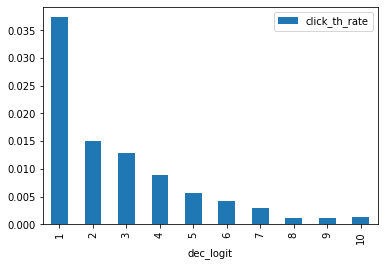

In [763]:
df_dec_logit.plot.bar(x = 'dec_logit', y = 'click_th_rate', use_index=True)

## Part IV: Lift, Gains, and Profit (15 points)

Use the `df_dec_logit DataFrame` you created in Part III for the following calculations.

> Note: Do NOT use any specialized packages to answer the questions below. Write the python code for the lift, gains, and profit tables from scratch and use seaborn, pandas, or matplotlib for the graphs

a. Write python code to generate a DataFrame with the cumulative proportion of impressions and the cumulative lift for each decile (3 points)

##### - Cumulative number of customers:  the number of customers up to and including that decile
##### - Cumulative proportion of customers: the proportion of customers up to and including that decile
##### - Cumulative number of buyers:  the number of buyers up to and including that decile
##### - Response rate:  the actual response rate for each decile, computed as the number of buyers divided by the number of customers for each decile
##### - Lift:  response rate for each decile / overall response rate
##### - Cumulative response rate: cumulative nr. buyers / cumulative nr. customers 
##### - Cumulative Lift: cumulative response rate / overall response rate
# 

In [620]:
cum_nr_impression = df_dec_logit['num_impress'].cumsum()
df_dec_logit['cum_nr_impression'] = cum_nr_impression

In [621]:
cum_impression_rate = cum_nr_impression/sum(df_dec_logit['num_impress'])
df_dec_logit['cum_impression_rate'] = cum_impression_rate

In [622]:
cum_nr_click = df_dec_logit['num_click'].cumsum()
df_dec_logit['cum_nr_click'] = cum_nr_click

In [623]:
cum_nr_click_rate = cum_nr_click/df_dec_logit['num_impress'].cumsum()
df_dec_logit['cum_nr_click_rate'] = cum_nr_click_rate

In [624]:
# insert your answer here 
lift_tab = df_dec_logit['click_th_rate']/sum(df_dec_logit['click_th_rate'])
df_dec_logit['lift_tab'] = lift_tab

In [625]:
cum_lift = df_dec_logit['cum_nr_click_rate']/(sum(df_dec_logit['num_click'])/sum(df_dec_logit['num_impress']))
df_dec_logit['cum_lift'] = cum_lift

In [626]:
lift_tab = pd.DataFrame({"lift":lift_tab, "cum_lift": cum_lift})
#lift_tab

In [627]:
lift_tab

,lift,cum_lift
dec_logit,,
1,0.379871,3.799786
2,0.177217,2.786775
3,0.155343,2.376446
4,0.110642,2.058705
5,0.055203,1.756646
6,0.025816,1.506837
7,0.025835,1.328556
8,0.011064,1.176273
9,0.014752,1.061940


b. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative lift per decile. Put cumulative lift on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

<AxesSubplot:xlabel='dec_logit'>

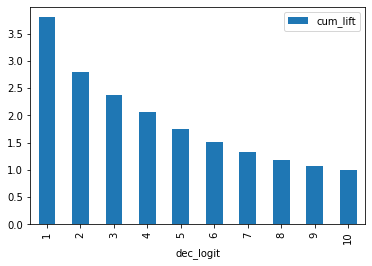

In [429]:
df_dec_logit.plot.bar(y = 'cum_lift', use_index=True)

c. Write python code to generate a DataFrame with the cumulative proportion of impressions and the cumulative gains for each decile (3 points)

##### - Gains: the proportion of the total number of responders (i.e., buyers) accounted for by each decile
##### - Cumulative gains: the proportion of responders (i.e., buyers) up to and including the decile, or simply the sum of the gains up to that decile
# 

In [430]:
# insert your answer here
gains_tab = df_dec_logit['num_click']/sum(df_dec_logit['num_click'])
df_dec_logit['gains_tab'] = gains_tab

In [431]:
gains_cum = df_dec_logit['cum_nr_click']/sum(df_dec_logit['num_click'])
df_dec_logit['gains_cum'] = gains_cum

In [574]:
gains_tab = pd.DataFrame({"gains" : gains_tab, "cum gains" : gains_cum})
gains_tab

,gains,cum gains
dec_logit,,
1,0.380074,0.380074
2,0.177122,0.557196
3,0.154982,0.712177
4,0.110701,0.822878
5,0.055351,0.878229
6,0.025830,0.904059
7,0.025830,0.929889
8,0.011070,0.940959
9,0.014760,0.955720


d. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative gains per decile along with a (diagonal) reference line to represent the "no model" scenario. Put cumulative gains on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

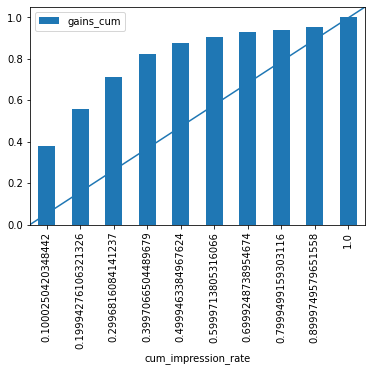

In [433]:
# insert your answer here
ax = df_dec_logit.plot.bar(x = 'cum_impression_rate', y = 'gains_cum')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)

e. Write python code to generate a table with the cumulative proportion of impressions and profits for each decile (3 points)

In [577]:
cost_per_1000_impression = 10
conversion_rate = 0.05
rev_per_gamer = 25

cost = df_dec_logit['num_impress'].div(1000)*cost_per_1000_impression
revenue = df_dec_logit['num_click']*rev_per_gamer*conversion_rate

In [580]:
# insert your answer here
profit_tab = revenue - cost
df_dec_logit['profit_tab'] = profit_tab
profit_cum = df_dec_logit['profit_tab'].cumsum()
df_dec_logit['profit_cum'] = profit_cum

In [581]:
profit_tab = pd.DataFrame({'profit': profit_tab, 'cum profit' : profit_cum})
profit_tab

,profit,cum profit
dec_logit,,
1,100.79,100.79
2,32.07,132.86
3,24.62,157.48
4,9.54,167.02
5,-9.27,157.75
6,-19.21,138.54
7,-19.19,119.35
8,-24.21,95.14
9,-22.96,72.18


In [436]:
df_dec_logit[['cum_impression_rate' , 'profit_tab', 'profit_cum']]

,cum_impression_rate,profit_tab,profit_cum
dec_logit,,,
1,0.100025,100.79,100.79
2,0.199943,32.07,132.86
3,0.299682,24.62,157.48
4,0.399707,9.54,167.02
5,0.499946,-9.27,157.75
6,0.599971,-19.21,138.54
7,0.699925,-19.19,119.35
8,0.799950,-24.21,95.14
9,0.899975,-22.96,72.18


f. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the profits per decile. Put profit on the Y-axis and cumulative proportion of impressions on the X-axis (2 points)

<AxesSubplot:xlabel='cum_impression_rate'>

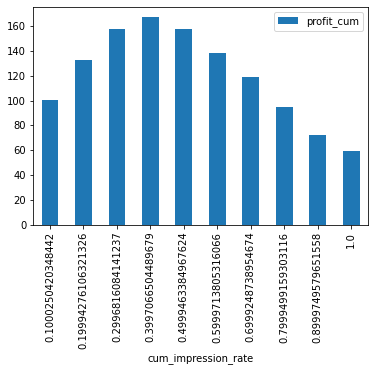

In [437]:
# insert your answer here
df_dec_logit.plot.bar(x = 'cum_impression_rate', y = 'profit_cum')

## Part V: Confusion matrix (10 points)

a. Create a DataFrame with elements from a "confusion matrix" based on the predictions from the logistic regression model you estimated in Part I (i.e., `pred_logit`). Again, use only data from the test set here (i.e., `training == 'test'`).

Use the financial assumptions mentioned above, and repeated in section VI below, to determine an appropriate cut-off (i.e., break-even). Calculate `accuracy` based on the confusion matrix you created (see <http://lab.rady.ucsd.edu/sawtooth/RBusinessAnalytics/logit_models.html> for an example using R) (2 points)

> Note: Do NOT use any specialized packages to construct the confusion matrix. Write the python code to construct the confusion matrix from scratch

In [406]:
tz_gaming[(tz_gaming['click_yes'] == 1) & (tz_gaming['training'] == 'test')]['pred_logit'].describe().round(6)

count    271.000000
mean       0.022745
std        0.026477
min        0.000000
25%        0.009511
50%        0.015828
75%        0.028137
max        0.257217
Name: pred_logit, dtype: float64

In [407]:
tz_gaming[(tz_gaming['click_yes'] == 0) & (tz_gaming['training'] == 'test')]['pred_logit'].describe().round(6)

count    27682.000000
mean         0.008654
std          0.012425
min          0.000000
25%          0.001355
50%          0.005296
75%          0.011873
max          0.368137
Name: pred_logit, dtype: float64

##### From the above stats, we can tell the no click observations is much more than yes click observations. These two group also has distinct means and distributions.

In [628]:
# Breakeven Point
BK_point = (10/1000)/(0.05*25)
BK_point

0.008

##### The breakeven point is determined at cost/margine like we learned in the Tuango case study.

In [629]:
# use the cumulative click through rate that yields highest profit as the breakeven point, 0.010730
true_click = tz_gaming[tz_gaming['training'] == 'test']['click_yes']
binom_pred = [1 if i > BK_point else 0 for i in tz_gaming[tz_gaming['training'] == 'test']['pred_logit']]
binom_pred.count(1)
#binom_pred
#len(true_click)

10882

In [630]:
TP = FP = TN = FN = TRUE = FALSE =  0
for i,j in zip(binom_pred, true_click):
    if i == 1:
        if i == j:
            TP += 1
            TRUE += 1
        else:
            FP += 1
            FALSE += 1
    else: 
        if i == j:
            TN += 1
            TRUE += 1
        else:
            FN += 1
            FALSE += 1
     

In [631]:
{'correct':TRUE, 'incorrect': FALSE}

{'correct': 17242, 'incorrect': 10711}

In [632]:
# confusion matrix
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)
cm_logit

,label,nr
0,TP,221
1,FP,10661
2,TN,17021
3,FN,50


In [633]:
accuracy_logit = TRUE/(TRUE + FALSE)# float
accuracy_logit

0.6168210925482059

b. Calculate a DataFrame with elements from a confusion matrix based on `pred_rnd` created in Part I and calculate `accuracy` based on the confusion matrix you created (2 points)

In [634]:
true_click = tz_gaming[tz_gaming['training'] == 'test']['click_yes']
binom_pred = [1 if i > BK_point else 0 for i in tz_gaming[tz_gaming['training'] == 'test']['pred_rnd']]

TP = FP = TN = FN = TRUE = FALSE =  0
for i,j in zip(binom_pred, true_click):
    if i == 1:
        if i == j:
            TP += 1
            TRUE += 1
        else:
            FP += 1
            FALSE += 1
    else: 
        if i == j:
            TN += 1
            TRUE += 1
        else:
            FN += 1
            FALSE += 1

{'correct':TRUE, 'incorrect': FALSE}

{'correct': 347, 'incorrect': 27606}

In [635]:
# confusion matrix
cm_rnd = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN]# TP, FP, TN, and FN values in that order
    }
)
cm_rnd

,label,nr
0,TP,271
1,FP,27606
2,TN,76
3,FN,0


In [636]:
accuracy_rnd = TRUE/(TRUE + FALSE) # float
accuracy_rnd

0.012413694415626229

c. Discuss the similarities and differences between the two confusion matrices. Which prediction (model) is best, based on the confusion matrix? Provide support for your conclusions (3 points)

##### - TP: True positive (predicted pos, actual pos)
##### - TN: True negative (predicted neg, actual neg)
##### - FP: False positive (predicted pos, actual neg)
##### - FN: False negative (predicted neg, actual pos)
# 

##### The accuracy of logit prediction is 0.6168210925482059, which is much higher than the accuracy of rnd prediction, 0.012413694415626229.
##### One similarity of these two is that they both have comparatively low FN predictions, which is predicted negative but actually positive. This is considered "good" in this particular case since we aim to get as many TP as possible since that is the main contributor to the profit. And having less FN in some degree reflects more TP predictions. Thus, we'd be more likely to earn than waste money.
##### Both predictions are over classifying positive values based on the 0.008 break even point but rnd_pred is simply trying to classify all values to 1 as it's trained from a simulated predictor variable so that the standard deviation or distribution is relatively small and normal. However, the logit_pred is more effective in predictions as it's trained model has more betas for the algorithm to yield more characterized predictions according to inputs. 
##### The difference is that logit_pred is trained with few variables corr. with the outcome variable, click_yes. However, the rnd_pred is a simulated variable that's normally distributed N(0,1), and was trained singularly to the outcome click_yes.
##### Therefore, in general, the logit_pred is better than the rnd_pred
# 

d. Recalculate the confusion matrices from V.a and V.b using 0.5 as the cutoff. Based on these new matrices, again discuss the similarities and differences. Which model is best based on these new confusion matrices? Provide support for your conclusions (3 points)

In [637]:
# confusion matrix

true_click = tz_gaming[tz_gaming['training'] == 'test']['click_yes']
binom_pred = [1 if i > 0.5 else 0 for i in tz_gaming[tz_gaming['training'] == 'test']['pred_logit']]

TP = FP = TN = FN = TRUE = FALSE =  0
for i,j in zip(binom_pred, true_click):
    if i == 1:
        if i == j:
            TP += 1
            TRUE += 1
        else:
            FP += 1
            FALSE += 1
    else: 
        if i == j:
            TN += 1
            TRUE += 1
        else:
            FN += 1
            FALSE += 1

cm_logit_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)

In [641]:
cm_logit_recalc

,label,nr
0,TP,0
1,FP,0
2,TN,27682
3,FN,271


In [638]:
accuracy_logit_recalc = TRUE/(TRUE + FALSE)# float
accuracy_logit_recalc

0.9903051550817443

In [642]:
# confusion matrix

true_click = tz_gaming[tz_gaming['training'] == 'test']['click_yes']
binom_pred = [1 if i > 0.5 else 0 for i in tz_gaming[tz_gaming['training'] == 'test']['pred_rnd']]

TP = FP = TN = FN = TRUE = FALSE =  0
for i,j in zip(binom_pred, true_click):
    if i == 1:
        if i == j:
            TP += 1
            TRUE += 1
        else:
            FP += 1
            FALSE += 1
    else: 
        if i == j:
            TN += 1
            TRUE += 1
        else:
            FN += 1
            FALSE += 1


cm_rnd_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)

In [643]:
cm_rnd_recalc

,label,nr
0,TP,0
1,FP,0
2,TN,27682
3,FN,271


In [644]:
accuracy_rnd_recalc = TRUE/(TRUE + FALSE) # float
accuracy_rnd_recalc

0.9903051550817443

##### When the break even point is sat to 0.5, both prediction approach yields only 0 value outcome since no prediction is greater than 0.5. Thus having extremely same high accuracy, 0.9903051550817443, which is also the proportion of 0 in the actual data.
##### The break even point of 0.5 is commonly used for logistic regression where there were ample training predictors and relatively low collinearity. In this particular case, when both model were trained with insufficient data (low r square) and high collinearity (high VIF's), 0.5 is not useful in classifying prediction outcomes at all.
##### Therefore, we can not provide solid selection between these two prediction method based on break even point of 0.5.
# 

## Part VI: Model comparison (12 points)


a. Create a new variable `target_logit` that is `True` if the predicted click-t(10/1000)/(0.05*25)hrough (`pred_logit`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [658]:
# insert your answer here
tz_gaming["target_logit"] = [True if i > BK_point else False for i in tz_gaming["pred_logit"]]
tz_gaming["target_logit"]

0         False
1          True
2         False
3          True
4         False
          ...  
115483    False
115484    False
115485     True
115486     True
115487     True
Name: target_logit, Length: 115488, dtype: bool

b. Create a new variable `target_rnd` that is `True` if the predicted click-through (`pred_rnd`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [659]:
# insert your answer here
tz_gaming["target_rnd"] = [True if i > BK_point else False for i in tz_gaming["pred_rnd"]]
tz_gaming["target_rnd"]

0         True
1         True
2         True
3         True
4         True
          ... 
115483    True
115484    True
115485    True
115486    True
115487    True
Name: target_rnd, Length: 115488, dtype: bool

c. Create a new variable `target_vneta` that is `True` if the predicted click-through (`pred_vneta`) probability is greater than the break-even response rate and `False` otherwise (1 point)

In [660]:
# insert your answer here
tz_gaming["target_vneta"] = [True if i > BK_point else False for i in tz_gaming["pred_vneta"]]
tz_gaming["target_vneta"]

0         False
1         False
2         False
3          True
4         False
          ...  
115483    False
115484    False
115485    False
115486     True
115487    False
Name: target_vneta, Length: 115488, dtype: bool

d. Based only on the test set (i.e, `training == "test"`), calculate the expected profit (in dollars) and the expected return on marketing expenditures (ROME) if TZ (1) `spams` everyone in the test set, (2) continues to target using their current approach (`pred_rnd`), (3) purchases the data from Vneta and uses the logistic regression from I (`pred_logit`) for targeting, or (4) used Vneta's data science consulting services (`pred_vneta`) (3 points)

> Note: For efficiency, you can adapt the `perf_calc_actual` function you created for the Tuango case to do the relevant performance calculations for the different models

In [661]:
# Given
cost_per_1000_impression = 10
conversion_rate = 0.05
rev_per_gamer = 25
Vneta_data_cost = 50000
Vneta_consulting_cost = 150000

In [662]:
#spam
tz_gaming["pred_spam"] = 1
num_impress = len(tz_gaming[tz_gaming['training'] == 'test']["pred_spam"])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1)])

cost = num_impress/1000*cost_per_1000_impression
rev = num_click * conversion_rate * rev_per_gamer
profit_spam = rev - cost
rome_spam = profit_spam/cost

In [663]:
# target using pred_rnd
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_rnd'] == True)])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_rnd'] == True)])

cost = num_impress/1000*cost_per_1000_impression
rev = num_click * conversion_rate * rev_per_gamer
profit_target_rnd = rev - cost
rome_target_rnd = profit_target_rnd/cost

In [738]:
# target using pred_logit
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_logit'] == True)] )
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_logit'] == True)])

cost = num_impress/1000*cost_per_1000_impression
rev = num_click * conversion_rate * rev_per_gamer
profit_target_logit = rev - cost - Vneta_data_cost
rome_target_logit = profit_target_logit/cost

In [739]:
# target using Vneta data
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_vneta'] == True)])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_vneta'] == True)])

cost = num_impress/1000*cost_per_1000_impression
rev = num_click * conversion_rate * rev_per_gamer
profit_target_consulting = rev - cost - Vneta_consulting_cost
rome_target_consulting = profit_target_consulting/cost

In [740]:
# calculate and add profit and ROME values for each approach
# to the mod_perf data frame
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True

mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_target_logit, profit_target_rnd, profit_target_consulting, profit_spam],
        "ROME": [rome_target_logit, rome_target_rnd,  rome_target_consulting, rome_spam]
    }
)
mod_perf

,model,profit,ROME
0,logit,-49832.57,-457.935765
1,rnd,59.98,0.215159
2,vneta,-149848.71,-3076.343872
3,spam,59.22,0.211856


e. Based on the results from VI.d discuss which of these 4 approaches you would recommend and why (2 points)

##### For only the testing data set, I would recommend targeting using rnd strategy as it yields the highest profit while having higher ROME than spam.(since the scale of neither logit's nor vneta's cost are comparable with the rest two, it's not fair to pull all four ROME into comparison) 
##### But the recommendation is not solid as both targeting logit or vneta consulting service has a large fixed cost especially for revenues of the small test data set. 
# 

f. Calculate the profit and ROME implications for each of the 4 options mentioned in VI.d if TZ purchases 20-million impression for the upcoming ad campaign (2 points)

> Note: For efficiency, you can adapt the `perf_calc` function you created for the Tuango case to do the relevant performance calculations for the different models.

In [707]:
# Given
rate = 20000000/len(tz_gaming[tz_gaming['training'] == 'test'])
rate

715.4867098343648

In [708]:
167.43 * 715.4867098343648 - 50000

69793.9398275677

In [723]:
#spam
tz_gaming["pred_spam"] = 1
num_impress = len(tz_gaming[tz_gaming['training'] == 'test']["pred_spam"])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1)])
rate = 20000000/len(tz_gaming[tz_gaming['training'] == 'test'])


cost = num_impress/1000*cost_per_1000_impression * rate
rev = num_click * conversion_rate * rev_per_gamer * rate
profit_spam_20 = rev - cost
rome_spam_20 = profit_spam_20/cost

In [724]:
# target using pred_rnd
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_rnd'] == True)])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_rnd'] == True)])
rate = 20000000/num_impress

cost = num_impress/1000*cost_per_1000_impression * rate
rev = num_click * conversion_rate * rev_per_gamer * rate
profit_target_rnd_20 = rev - cost
rome_target_rnd_20 = profit_target_rnd_20/cost

In [741]:
# target using pred_logit
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_logit'] == True)] )
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_logit'] == True)])
rate = 20000000/num_impress

cost = 20000000/1000*cost_per_1000_impression 
rev = num_click * conversion_rate * rev_per_gamer * rate
profit_target_logit_20 = rev - cost - Vneta_data_cost
rome_target_logit_20 = profit_target_logit_20/cost

In [742]:
# target using Vneta data
num_impress = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['target_vneta'] == True)])
num_click = len(tz_gaming[(tz_gaming['training'] == 'test') & (tz_gaming['click_yes'] == 1) & (tz_gaming['target_vneta'] == True)])
rate = 20000000/num_impress

cost = 20000000/1000*cost_per_1000_impression 
rev = num_click * conversion_rate * rev_per_gamer * rate
profit_target_consulting_20 = rev - cost - Vneta_consulting_cost
rome_target_consulting_20 = profit_target_consulting_20/cost

In [743]:
# insert your answer here
mod_perf_20M = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_target_logit_20, profit_target_rnd_20, profit_target_consulting_20, profit_spam_20],
        "ROME": [rome_target_logit_20, rome_target_rnd_20, rome_target_consulting_20, rome_spam_20]
    }
)
mod_perf_20M

,model,profit,ROME
0,logit,257719.169270,1.288596
1,rnd,43031.890089,0.215159
2,vneta,471186.614658,2.355933
3,spam,42371.122956,0.211856


g. Based on the results from VI.f, discuss which of the 4 approaches you would recommend to put into production and why. Is your recommendation different from VI.e? Why (not) (2 points)

##### Yes, we would make different recommendations.
##### From the above table, we would recommend using vneta method as it yields highest profit with highest ROME.
##### A higher ROME, suggest higher return on marketing expenditure, for which the business growth is more safe thus tolerates more variation in cost.
# 

## Testing

Run the cell below to determine if all of required variables are available and are of the correct type

In [588]:
print("===============================================")
print("Testing for code completeness")
print("===============================================")

if "tz_gaming" not in locals():
    raise NameError("Did you not load the tz_gaming data?")
else:
    if not hasattr(tz_gaming, "click_yes"):
        raise NameError("tz_gaming should have a variable 'click_yes'")
        
    ### section I
    if "lr" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr'")
    if not hasattr(tz_gaming, "pred_logit"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_logit'")
    if "lr_std" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_std'")
    if "lr_rnd" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_rnd'")
    if not hasattr(tz_gaming, "pred_rnd"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_rnd'")
        
    ### section II
    if "lr_mc1" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc1'")
    if "lr_mc2" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc2'")
    if "lr_mc3" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc3'")
    
    ## section III
    if not hasattr(tz_gaming, "dec_logit"):
        raise NameError("Part III: tz_gaming should have a variable 'dec_logit'")
    if "df_dec_logit" not in locals():
        raise NameError("Part III: Your code should have a DataFrame called 'df_dec_logit'")
    elif type(df_dec_logit) != pd.DataFrame:
        raise NameError("Part III: 'df_dec_logit' should be a pandas DataFrame")
        
    ## section IV
    if "lift_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'lift_tab'")
    elif type(lift_tab) != pd.DataFrame:
        raise NameError("Part IV: 'lift_tab' should be a pandas DataFrame")
    if "gains_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'gains_tab'")
    elif type(gains_tab) != pd.DataFrame:
        raise NameError("Part IV: 'gains_tab' should be a pandas DataFrame")
    if "profit_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'profit_tab'")
    elif type(profit_tab) != pd.DataFrame:
        raise NameError("Part IV: 'profit_tab' should be a pandas DataFrame")
        
    ## section V
    if "cm_logit" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit'")
    else:
        if type(cm_logit) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit, "label"):
                raise NameError("Part V: 'cm_logit' should have a column 'label'")
            elif not all(cm_logit.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit, "nr"):
                raise NameError("Part V: 'cm_logit' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit.nr]):
                raise NameError("Part V: 'cm_logit.nr' values should be of type int or float")
                
    if "accuracy_logit" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit'")
    elif not (isinstance(accuracy_logit, np.floating) or isinstance(accuracy_logit, float)):
        raise NameError("Part V: 'accuracy_logit' should be of type int or float")
        
    if "cm_rnd" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd'")
    else:
        if type(cm_rnd) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd, "label"):
                raise NameError("Part V: 'cm_rnd' should have a column 'label'")
            elif not all(cm_rnd.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd, "nr"):
                raise NameError("Part V: 'cm_rnd' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd.nr]):
                raise NameError("Part V: 'cm_rnd.nr' values should be of type int or float")
                
    if "accuracy_rnd" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd'")
    elif not (isinstance(accuracy_rnd, np.floating) or isinstance(accuracy_rnd, float)):
        raise NameError("Part V: 'accuracy_rnd' should be of type float")
 
    if "cm_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit_recalc'")
    else:
        if type(cm_logit_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit_recalc, "label"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'label'")
            elif not all(cm_logit_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit_recalc.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit_recalc, "nr"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit_recalc.nr]):
                raise NameError("Part V: 'cm_logit_recalc.nr' values should be of type int or float")
                
    if "accuracy_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit_recalc'")
    elif not (isinstance(accuracy_logit_recalc, np.floating) or isinstance(accuracy_logit_recalc, float)):
        raise NameError("Part V: 'accuracy_logit_recalc' should be of type int or float")
        
    if "cm_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd_recalc'")
    else:
        if type(cm_rnd_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd_recalc, "label"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'label'")
            elif not all(cm_rnd_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label_recalc' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd_recalc, "nr"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd_recalc.nr]):
                raise NameError("Part V: 'cm_rnd_recalc.nr' values should be of type int or float")
                
    if "accuracy_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd_recalc'")
    elif not (isinstance(accuracy_rnd_recalc, np.floating) or isinstance(accuracy_rnd_recalc, float)):
        raise NameError("Part V: 'accuracy_rnd_recalc' should be of type float")

 
    ## section VI
    if not hasattr(tz_gaming, "target_logit"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_logit'")
    if not hasattr(tz_gaming, "target_rnd"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_rnd'")
    if not hasattr(tz_gaming, "target_vneta"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_vneta'")
    if not hasattr(tz_gaming, "target_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_spam'")
    if not hasattr(tz_gaming, "pred_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'pred_spam'")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf, "profit"):
                raise NameError("Part VI: 'mod_perf' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf' should be of type float")
 
            if not hasattr(mod_perf, "ROME"):
                raise NameError("Part VI: 'mod_perf' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf' should be of type float")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf_20M) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf_20M' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf_20M, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf_20M.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf_20M' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf_20M, "profit"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf_20M' should be of type float")
 
            if not hasattr(mod_perf_20M, "ROME"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf_20M' should be of type float")
 
 
print("===============================================")
print("Testing complete")
print("===============================================")

Testing for code completeness
Testing complete
